### Eric Maxwell
### CSC 570R
### Optional Challange Titanic Survival

In [1]:
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd

<hr style="height:2px">
### Get data

In [2]:
#Import data and create dependent variable
X = pd.read_csv("train.csv")
y = X.pop("Survived")

In [3]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<hr style="height:2px">
### Data Prep

In [4]:
#Display columns
X.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

#### Introduce title variable gathered from Name

In [5]:
#Get name title which starts after first comma and ends with a period
X['title'] = X['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())

In [6]:
#Get title value counts
X.title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Lady              1
the Countess      1
Don               1
Sir               1
Capt              1
Jonkheer          1
Ms                1
Mme               1
Name: title, dtype: int64

#### Check mean ages for corresponding titles

In [7]:
#Calculate mean age for the most common titles
T = ['Mr', 'Mrs', 'Miss', 'Ms', 'Master', 'Dr', 'Rev']
for t in T:
    print(t,"mean age: %0.1f" %X[X.title == t].Age.mean())

Mr mean age: 32.4
Mrs mean age: 35.9
Miss mean age: 21.8
Ms mean age: 28.0
Master mean age: 4.6
Dr mean age: 42.0
Rev mean age: 43.2


#### Replacing missing ages with title mean seems more appropriate than using over all age mean

In [8]:
#Fill missing ages with the mean age for the corresponding title
X['Age'].fillna(X['title'].map(lambda x: X[X.title == x].Age.mean()), inplace=True)

#### Create a new variable called family_members. This will be the total number of family members aboard.

In [9]:
#Total family members is the number of parents/childer plus number of siblings/spoues.
X['family_members'] = X['Parch'] + X['SibSp']

#### Check names of passengers who have the same ticket number on tickets with high value counts.

In [10]:
print(X[(X.Ticket == "CA. 2343")].Name)
print(X[(X.Ticket=="347082")].Name)

159           Sage, Master. Thomas Henry
180         Sage, Miss. Constance Gladys
201                  Sage, Mr. Frederick
324             Sage, Mr. George John Jr
792              Sage, Miss. Stella Anna
846             Sage, Mr. Douglas Bullen
863    Sage, Miss. Dorothy Edith "Dolly"
Name: Name, dtype: object
13                           Andersson, Mr. Anders Johan
119                    Andersson, Miss. Ellis Anna Maria
541                 Andersson, Miss. Ingeborg Constanzia
542                    Andersson, Miss. Sigrid Elisabeth
610    Andersson, Mrs. Anders Johan (Alfrida Konstant...
813                   Andersson, Miss. Ebba Iris Alfrida
850              Andersson, Master. Sigvard Harald Elias
Name: Name, dtype: object


#### They all have the same last name, which indicates family members probably traveled on one ticket. Dividing the Fare for the ticket by the number of family members should give a better estimate of average fare per person.

In [11]:
#Families tend to have the same ticket number. Average fare for families will be fare divided by number of family members.
X['Fare'] = X['Fare']/(X['family_members']+1)

#### Create numeric variables from variables which are still categorical and drop unused variables.

In [12]:
#Create dummy variable for sex.  Male is 0 and Female is 1.
X['Sex'] = pd.get_dummies(X.Sex)["female"]

#Change cabin variable to numeric by mapping the starting letter to a number
X['Cabin'] = X['Cabin'].str[0].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8})
X['Cabin'].fillna(0, inplace=True)

#Map each embarked category to a number.
X['Embarked'].fillna('S', inplace=True)
X['Embarked'] = X['Embarked'].map({'C':0, 'Q':1, 'S':2})

#Only the most common titles will be mapped unique numbers.  All other titles will be grouped together with 0.
X['title'] = X['title'].map({"Mr":1, "Miss":2, "Mrs":3, "Ms":3, "Master":4, "Dr":5, "Rev":6})
X['title'].fillna(0, inplace=True)

#Drop unused Variables
X.drop(['PassengerId', 'Name', 'Parch', 'SibSp', 'Ticket'], axis=1, inplace=True)

#### Display data frame

In [13]:
X

,Pclass,Sex,Age,Fare,Cabin,Embarked,title,family_members
0,3,0,22.000000,3.625000,0.0,2,1.0,1
1,1,1,38.000000,35.641650,3.0,0,3.0,1
2,3,1,26.000000,7.925000,0.0,2,2.0,0
3,1,1,35.000000,26.550000,3.0,2,3.0,1
4,3,0,35.000000,8.050000,0.0,2,1.0,0
5,3,0,32.368090,8.458300,0.0,1,1.0,0
6,1,0,54.000000,51.862500,5.0,2,1.0,0
7,3,0,2.000000,4.215000,0.0,2,4.0,4
8,3,1,27.000000,3.711100,0.0,2,3.0,2
9,2,1,14.000000,15.035400,0.0,0,3.0,1


<hr style="height:2px">
### Create Random Forest Regressor and check feature importance

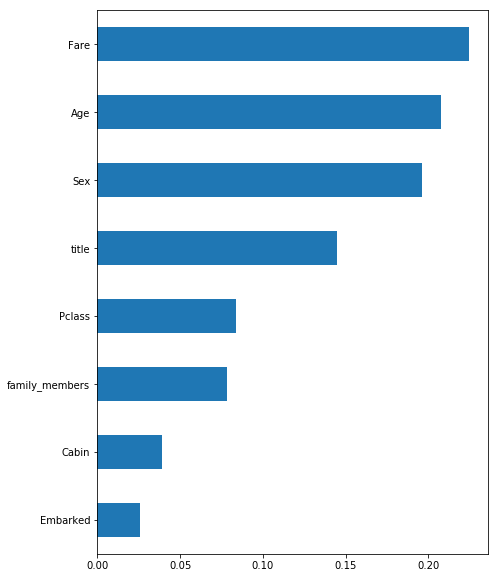

In [14]:
rfr = RandomForestRegressor(500, n_jobs=-1, random_state=42)
rfr.fit(X,y)
feature_importances = pd.Series(rfr.feature_importances_, index=X.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind="barh", figsize=(7,10));

#### Drop variables with low feature importance

In [15]:
X.drop(['Embarked', 'Cabin'], axis=1, inplace=True)

<hr style="height:2px">
##### Create Random Forest Regressor Classifier and get pre-optimized AUC score

In [16]:
#Instantiate random forest regressor
model = RandomForestRegressor(500, oob_score=True, n_jobs=-1, random_state=42)
#Fit the classifier to the data
model.fit(X, y)
#Display ROC_AUC Score
print ("AUC: ", roc_auc_score(y, model.oob_prediction_))

AUC:  0.873555321211


##### Optimize Parameters

In [17]:
results = []
n_estimator_options = [50, 100, 200, 500, 1000, 2000] # 
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

best_auc = 0
t = 0
l = 0
f = 0

for num_leaves in min_samples_leaf_options:
    for num_trees in n_estimator_options:
        for num_features in max_features_options:
            
            model = RandomForestRegressor(n_estimators=num_trees, 
                                          oob_score=True, 
                                          n_jobs=-1, 
                                          random_state=42, 
                                          max_features=num_features, 
                                          min_samples_leaf=num_leaves)
            model.fit(X, y)
    
            if (roc_auc_score(y, model.oob_prediction_)) > best_auc :
                best_auc = roc_auc_score(y, model.oob_prediction_)
                t = num_trees
                l = num_leaves
                f = num_features
                best_model = model
                
print("n_estimators:",t,"; max_features:",f,"; min_samples_leaf:",l)
print("AUC: ",best_auc)
print("AUC: ", roc_auc_score(y,best_model.oob_prediction_))

n_estimators: 1000 ; max_features: sqrt ; min_samples_leaf: 3
AUC:  0.88619925649
AUC:  0.88619925649


<hr style="height:2px">
#### ROC_AUC Score

In [18]:
print("AUC:",roc_auc_score(y, best_model.oob_prediction_))

AUC: 0.88619925649


### Final AUC = 0.8862